## Arabic Twitter Sentiment Analysis

In [157]:
import gensim
import re
import pandas as pd
import numpy as np
import codecs
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import text_to_word_sequence
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

MAX_NUM_WORDS = 20000
VALIDATION_SPLIT = 0.2

## Load some cleaning and helper functions

In [53]:
def get_stop_words():
    path = "../Data/stop_words.txt"
    stop_words = []
    with codecs.open(path, "r", encoding="utf-8", errors="ignore") as myfile:
        stop_words = myfile.readlines()
    stop_words = [word.strip() for word in stop_words]
    return stop_words

def get_text_sequences(texts):
    tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)
    word_index = tokenizer.word_index
    data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
    return data, word_index

# Clean/Normalize Arabic Text

def clean_str(text):
    search = ["أ","إ","آ","ة","_","-","/",".","،"," و "," يا ",'"',"ـ","'","ى","\\",'\n', '\t','&quot;','?','؟','!']
    replace = ["ا","ا","ا","ه"," "," ","","",""," و"," يا","","","","ي","",' ', ' ',' ',' ? ',' ؟ ',' ! ']
    
    #remove tashkeel
    p_tashkeel = re.compile(r'[\u0617-\u061A\u064B-\u0652]')
    text = re.sub(p_tashkeel,"", text)
    
    #remove longation
    p_longation = re.compile(r'(.)\1+')
    subst = r"\1\1"
    text = re.sub(p_longation, subst, text)
    
    text = text.replace('وو', 'و')
    text = text.replace('يي', 'ي')
    text = text.replace('اا', 'ا')
    
    for i in range(0, len(search)):
        text = text.replace(search[i], replace[i])
    
    #trim    
    text = text.strip()

    return text

#clean_str(u'القاهرة')

## Load Data and Embeddings and convert them to Numpy Array

Lets clean the text in our dataframe

In [113]:
df = pd.read_csv("../Data/final.csv")
## Clean and drop stop words
df['text'] = df.text.apply(lambda x: clean_str(x))
stop_words = r'\b(?:{})\b'.format('|'.join(get_stop_words()))
df['text'] = df['text'].str.replace(stop_words, '')
df['binary_sentiment'] = df.sentiment.map(dict(positive=1, negative=0))
df = shuffle(df)

In [114]:
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['binary_sentiment'], test_size=0.20, random_state=42)

In [151]:
tokenizer = Tokenizer(num_words= MAX_NUM_WORDS)
tokenizer.fit_on_texts(X_train)

sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)
data = pad_sequences(sequences, maxlen=100)
test_data = pad_sequences(test_sequences, maxlen=100)

## Raw LSTM Model

In [152]:
model_lstm = Sequential()
model_lstm.add(Embedding(20000, 100, input_length=100))
model_lstm.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model_lstm.add(Dense(1, activation='sigmoid'))
model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [153]:
history = model_lstm.fit(data, y_train, validation_split=0.4, epochs=3)

/Users/evanwilliams/.pyenv/versions/3.7.6/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 28219 samples, validate on 18813 samples
Epoch 1/3
28219/28219 [==============================] - 84s 3ms/step - loss: 0.2481 - accuracy: 0.8922 - val_loss: 0.1681 - val_accuracy: 0.9308
Epoch 2/3
28219/28219 [==============================] - 83s 3ms/step - loss: 0.1035 - accuracy: 0.9600 - val_loss: 0.1851 - val_accuracy: 0.9253
Epoch 3/3
28219/28219 [==============================] - 84s 3ms/step - loss: 0.0669 - accuracy: 0.9751 - val_loss: 0.2343 - val_accuracy: 0.9245


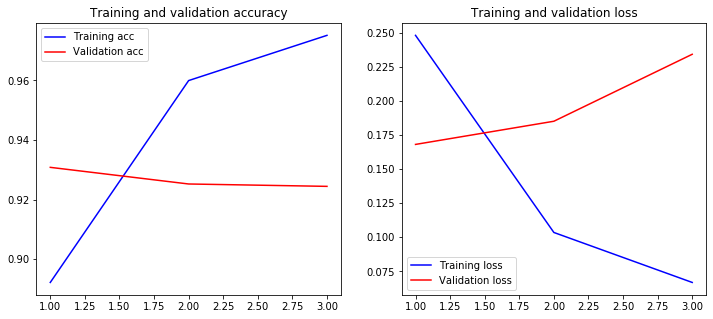

In [158]:
def plot_history(model):
    acc = model.history['accuracy']
    val_acc = model.history['val_accuracy']
    loss = model.history['loss']
    val_loss = model.history['val_loss']
    x = range(1, len(acc) + 1)
    
    plt.figure(figsize = (12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label = 'Training acc')
    plt.plot(x, val_acc, 'r', label = "Validation acc")
    plt.title("Training and validation accuracy")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, "b", label = 'Training loss')
    plt.plot(x, val_loss, 'r', label = 'Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
plot_history(history)

In [149]:
def class_report(model):
    yhat_probs = model.predict(test_data, verbose = 0)
    yhat_classes = model.predict_classes(test_data, verbose = 0)
    yhat_probs = yhat_probs[:, 0]
    yhat_classes = yhat_classes[:, 0]
    
    report = classification_report(y_test, yhat_classes)
    print(report)

In [130]:
#class_report(model_lstm) # not bad at all! - 3 epochs
#              precision    recall  f1-score   support
#
#           0       0.92      0.93      0.93      5887
#           1       0.93      0.92      0.92      5872
#
#    accuracy                           0.92     11759
#   macro avg       0.92      0.92      0.92     11759
#weighted avg       0.92      0.92      0.92     11759


              precision    recall  f1-score   support

           0       0.92      0.93      0.93      5887
           1       0.93      0.92      0.92      5872

    accuracy                           0.92     11759
   macro avg       0.92      0.92      0.92     11759
weighted avg       0.92      0.92      0.92     11759



In [159]:
class_report(model_lstm)

              precision    recall  f1-score   support

           0       0.93      0.93      0.93      5887
           1       0.93      0.93      0.93      5872

    accuracy                           0.93     11759
   macro avg       0.93      0.93      0.93     11759
weighted avg       0.93      0.93      0.93     11759



In [161]:
import pickle

with open("arabic_sentiment_lstm.pickle", "wb") as f:
    pickle.dump(tokenizer, f)
model_lstm.save('../Models/arabic_sentiment_lstm.hdf5')

## With AraVec Embeddings

In [131]:
# load the model
model = gensim.models.Word2Vec.load('../Embeddings/tweets_sg_300')

In [133]:
# convert the wv word vectors into a numpy matrix that is suitable for insertion
# into our TensorFlow and Keras models
EMBEDDING_DIM = 300
embedding_matrix = np.zeros((len(model.wv.vocab), EMBEDDING_DIM))
for i in range(len(model.wv.vocab)):
    embedding_vector = model.wv[model.wv.index2word[i]]
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [69]:
# fuck it lets see how this goes

In [134]:
model_ar = Sequential()
model_ar.add(Embedding(len(model.wv.vocab), 300, input_length=100, weights=[embedding_matrix], trainable=False))
model_ar.add(Dropout(0.2))
model_ar.add(Conv1D(64, 5, activation='relu'))
model_ar.add(MaxPooling1D(pool_size=4))
model_ar.add(LSTM(100))
model_ar.add(Dense(1, activation='sigmoid'))
model_ar.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [136]:
## Fit train data
model_ar.fit(data, y_train, validation_split=0.4, epochs=15)

Train on 28219 samples, validate on 18813 samples
Epoch 1/3
28219/28219 [==============================] - 36s 1ms/step - loss: 0.4380 - accuracy: 0.7760 - val_loss: 0.2916 - val_accuracy: 0.8735
Epoch 2/3
28219/28219 [==============================] - 37s 1ms/step - loss: 0.2456 - accuracy: 0.8937 - val_loss: 0.2468 - val_accuracy: 0.8928
Epoch 3/3
28219/28219 [==============================] - 37s 1ms/step - loss: 0.1749 - accuracy: 0.9254 - val_loss: 0.2431 - val_accuracy: 0.8994


Freeze our embeddings so that they aren't updated during training.

In [26]:
saved_embeddings = tf.constant(embedding_matrix)
embedding = tf.Variable(initial_value=saved_embeddings, trainable=False)

## Set up the model

In [ ]:

tokenizer = Tokenizer(nb_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

labels = to_categorical(np.asarray(labels))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# split the data into a training set and a validation set
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]